# Downloading Mobotix data from Sage Cloud
One of the most important experimental device is steerable IR camera driven my the waggle node. With the help of waggle plugin this camera was controlled to get the variety of images of the surrounding.

These images were captured at the Pier EPCAPE observational site as part of the [ARM NSF project](https://www.arm.gov/research/campaigns/amf2023epcape-piersedge). Access to this data may require special permission, which can be obtained by contacting the project's PIs. The images in this notebook are presented for educational purposes with the approval of the project investigators. No identifiable humans are present in these images.

In [ ]:
import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt
import os
import glob


import sage_data_client

In [62]:
df = sage_data_client.query(
    start="2023-11-08T00:00:09Z",
    end="2023-12-28T23:23:24Z", 
    #start="2023-11-02T01:16:09Z",
    #end="2023-11-02T01:30:24Z", 
    filter={
        "plugin": ".*mobotix-scan.*",
        "vsn": "W056",
        "name": "upload",
        "filename": "*.nc"
    }
)
df=df.sort_values('timestamp')
df



,timestamp,name,value,meta.filename,meta.host,meta.job,meta.node,meta.plugin,meta.task,meta.vsn,meta.zone
0,2023-11-08 00:01:57.572026426+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-11-08...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
1,2023-11-08 00:02:03.043871981+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-11-08...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
2,2023-11-08 00:02:08.183000306+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-11-08...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
3,2023-11-08 00:02:13.234372428+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-11-08...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
4,2023-11-08 00:02:18.407291752+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-11-08...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
...,...,...,...,...,...,...,...,...,...,...,...
113368,2023-12-28 23:19:22.085926136+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-12-28...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps-560,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
113369,2023-12-28 23:19:27.881340296+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-12-28...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps-560,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
113370,2023-12-28 23:19:33.608715114+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-12-28...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps-560,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core
113371,2023-12-28 23:19:39.513979880+00:00,upload,https://storage.sagecontinuum.org/api/v1/data/...,right_336x252_14bit.thermal.celsius_2023-12-28...,000048b02d3af49f.ws-nxcore,mobotix-scan-scripps-560,000048b02d3af49f,registry.sagecontinuum.org/bhupendraraut/mobot...,mobotix-scan-scripps,W056,core


Now that we got the list of files to download, we will use requests library to download the files.

In [ ]:
import pandas as pd
import requests
import os
from requests.auth import HTTPBasicAuth

uname = 'bhupendraraut'
upass = '7s5df7aw5s7fstf' # get it from waggle admins

def download_files_from_dataframe(df, download_path, uname, upass):
    # check download directory
    if not os.path.exists(download_path):
        os.makedirs(download_path)
    
    for index, row in df.iterrows():
        # 'value' column has url
        url = row['value']
        
        filename = url.split('/')[-1] 
        
        # Download the file content, including Basic Auth credentials in the request
        response = requests.get(url, auth=HTTPBasicAuth(uname, upass))
        if response.status_code == 200:
            # Define the path to save the file
            file_path = os.path.join(download_path, filename)
            # Write the content to a new file
            with open(file_path, 'wb') as file:
                file.write(response.content)
            #print(f"Downloaded {filename} to {file_path}")
        else:
            print(f"Failed to download {url}, status code: {response.status_code}")


download_files_from_dataframe(df, '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc_4pano', uname, upass)


Failed to download https://storage.sagecontinuum.org/api/v1/data/mobotix-scan-scripps/sage-mobotix-scan-scripps-0.23.11.02/000048b02d3af49f/1699703281301112921-right_336x252_14bit.thermal.celsius_2023-11-11T114801_Pt1-right-S4xD500ms_Img18.nc, status code: 500
Failed to download https://storage.sagecontinuum.org/api/v1/data/mobotix-scan-scripps/sage-mobotix-scan-scripps-0.23.11.02/000048b02d3af49f/1699777195906776081-right_336x252_14bit.thermal.celsius_2023-11-12T081955_Pt3-right-S4xD1000ms_Img5.nc, status code: 500
Failed to download https://storage.sagecontinuum.org/api/v1/data/mobotix-scan-scripps/sage-mobotix-scan-scripps-0.23.11.02/000048b02d3af49f/1699777880316082260-right_336x252_14bit.thermal.celsius_2023-11-12T083120_Pt1-right-S4xD500ms_Img0.nc, status code: 500
Failed to download https://storage.sagecontinuum.org/api/v1/data/mobotix-scan-scripps/sage-mobotix-scan-scripps-0.23.11.02/000048b02d3af49f/1699777886612208572-right_336x252_14bit.thermal.celsius_2023-11-12T083126_Pt1-

Processing file: /Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698887791388219639-right_336x252_14bit.thermal.celsius_position5.nc
Time index: 0, Position index: 4
Temperature data shape: (1, 252, 336)
Processing file: /Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888239474853067-right_336x252_14bit.thermal.celsius_position18.nc
Time index: 1, Position index: 17
Temperature data shape: (1, 252, 336)
Processing file: /Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888212874799157-right_336x252_14bit.thermal.celsius_position6.nc
Time index: 2, Position index: 5
Temperature data shape: (1, 252, 336)
Processing file: /Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888341872455532-right_336x252_14bit.thermal.celsius_position31.nc
Time index: 3, Position index: 30
Temperature data shape: (1, 252, 336)
Processing file: /Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888284174532774-right_336x252_14bit.thermal.celsius_position7.

# plotting

In [7]:
import xarray as xr
from xmovie import Movie
import glob

/Users/bhupendra/anaconda3/envs/data/lib/python3.12/site-packages/xmovie/core.py:21: UserWarning: Optional dependency `tqdm` not found. This will make progressbars a lot nicer.     Install with `conda install -c conda-forge tqdm`
  warnings.warn(


In [12]:
files = glob.glob('/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/*.nc')
files


['/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698887791388219639-right_336x252_14bit.thermal.celsius_position5.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888239474853067-right_336x252_14bit.thermal.celsius_position18.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888212874799157-right_336x252_14bit.thermal.celsius_position6.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888341872455532-right_336x252_14bit.thermal.celsius_position31.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698888284174532774-right_336x252_14bit.thermal.celsius_position7.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698887930911253997-right_336x252_14bit.thermal.celsius_position3.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698887894874008967-right_336x252_14bit.thermal.celsius_position18.nc',
 '/Users/bhupendra/projects/epcape_pier/data/downloaded/nc/1698887823314381824-right_33

In [13]:
ds = xr.open_mfdataset(files[0:100], combine='by_coords')
ds

<xarray.Dataset> Size: 33MB
Dimensions:      (time: 48, y: 252, x: 336)
Coordinates:
  * x            (x) int32 1kB 0 1 2 3 4 5 6 7 ... 329 330 331 332 333 334 335
  * y            (y) int32 1kB 0 1 2 3 4 5 6 7 ... 245 246 247 248 249 250 251
  * time         (time) datetime64[ns] 384B 2023-11-02T01:16:21.497982720 ......
Data variables:
    temperature  (time, y, x) float64 33MB dask.array<chunksize=(1, 252, 336), meta=np.ndarray>
Attributes:
    sensor:                       right
    bit depth:                    14 bit
    width:                        336
    height:                       252
    resolution:                   high
    advanced radiometry support:  yes
    unit:                         degrees Celsius

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_4071/347579880.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


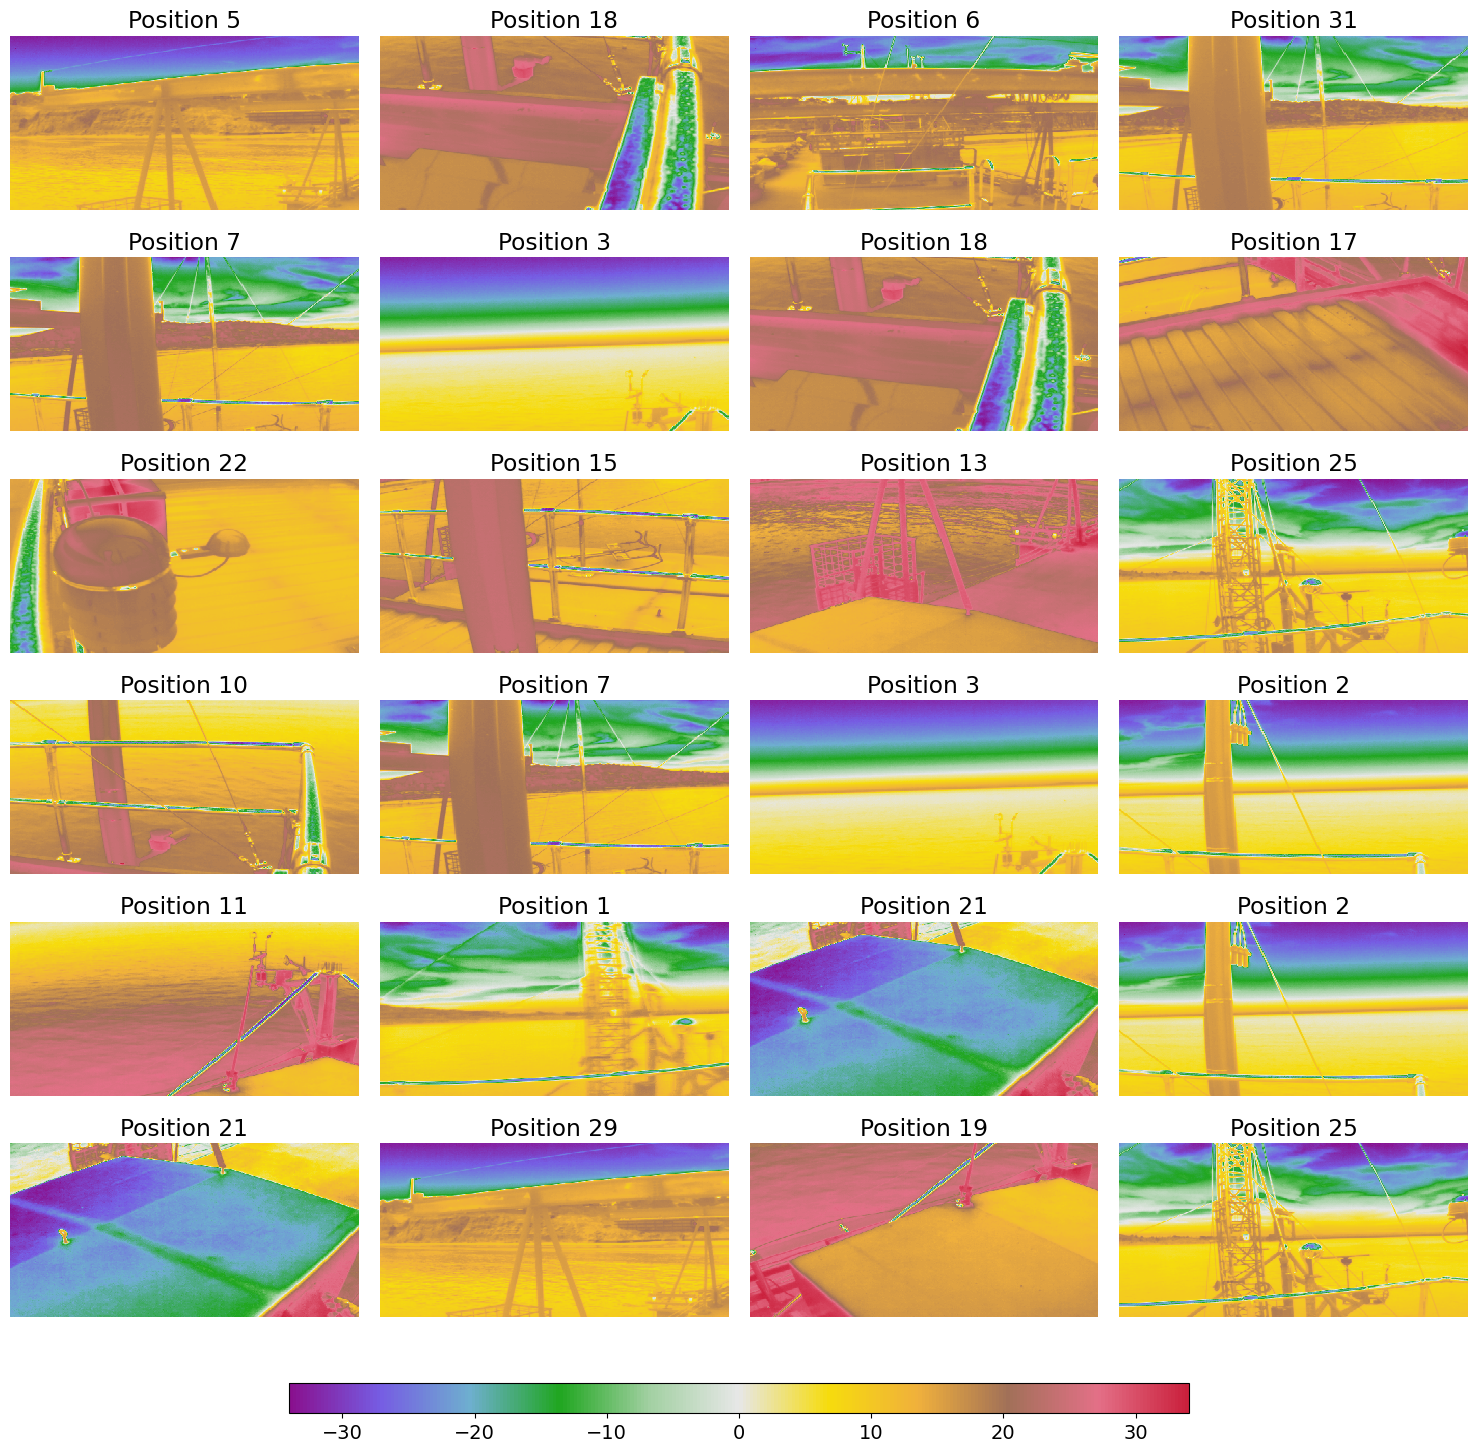

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

nrows = 6
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

axes = axes.flatten()

# Plot only the first 24 positions for brevity
for i in range(24):
    ax = axes[i]
    position = int(files[i].split('_')[-1].replace('position', '').replace('.nc', ''))
    im = ds.temperature.isel(time=position-1).plot(ax=ax, add_colorbar=False, cmap='Carbone11')
    ax.set_title(f'Position {position}')
    ax.axis('off')
    # Rotate the image
    ax.invert_yaxis()


cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [7]:
mov = Movie(ds.temperature,cmap='viridis')
mov.save('/Users/bhupendra/projects/epcape_pier/data/out/epcape_pos1.mp4')

/Users/bhupendra/anaconda3/envs/data/lib/python3.12/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/bhupendra/anaconda3/envs/data/lib/python3.12/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


Movie created at epcape_pos1.mp4


In [51]:
import requests
from requests.auth import HTTPBasicAuth


url='https://storage.sagecontinuum.org/api/v1/data/mobotix-scan-scripps/sage-mobotix-scan-scripps-0.23.4.24/000048b02d3af49f/1686188251682620043-6144x2048_position1.jpg'

resp = requests.get(url, auth=HTTPBasicAuth(uname, upass))
resp

<Response [200]>